In [1]:
import sys
sys.path.append('..')

In [2]:
from minbpe import BasicTokenizer

tokenizer = BasicTokenizer()
tokenizer.load(model_file="../Data/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: BasicTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

In [4]:
import torch
torch.manual_seed(3647)

In [5]:
from transformer.model import GPTLanguageModel

block_size = 512
n_embd = 128
n_head = 8
n_layer = 1
dropout = 0.2
batch_size = 128
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.529418 M parameters


In [6]:
with open("../Data/combined_text.txt", "r", encoding='utf-8') as f:
    text_sequence = f.read()

encoded_text_sequence = tokenizer.encode(text_sequence)
len(encoded_text_sequence)

28891

In [7]:
data = torch.tensor(encoded_text_sequence, dtype=torch.long)
split_index = int(0.9*len(data))
train_data = data[:split_index]
val_data = data[split_index:]

In [8]:
from typing import Tuple


def get_batch(split: str) -> Tuple[torch.Tensor, torch.Tensor]:
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    index = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in index])
    y = torch.stack([data[i+1:i+block_size+1] for i in index])
    x, y = x.to(device), y.to(device)
    return x, y

In [9]:
x, y = get_batch('train')
x.shape, y.shape

(torch.Size([128, 512]), torch.Size([128, 512]))

In [10]:
from typing import Dict

eval_iters = 200


@torch.no_grad()
def estimate_loss() -> Dict:
    output = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            _, loss = model(x, y)
            losses[k] = loss.item()
        output[split] = losses.mean()
    model.train()
    return output

In [11]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [13]:
import os
import warnings

# --- Disable Triton checks ---
os.environ["TORCHINDUCTOR_DISABLE_TRITON"] = "1"

# --- Suppress TorchDynamo / Inductor warnings ---
warnings.filterwarnings("ignore", category=UserWarning)

# Optional: fully disable TorchDynamo verbose logging
import torch._dynamo as dynamo
dynamo.reset()
dynamo.config.verbose = 0
dynamo.config.suppress_errors = True

In [15]:
max_iters = 1
eval_interval = 10
learning_rate = 1e-4
save_interval = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for iteration in range(max_iters):
    if iteration % eval_interval == 0 or iteration == max_iters - 1:
        losses = estimate_loss()
        print(
            f"step {iteration}: "
            f"train loss {losses['train']:.4f}, "
            f"val loss {losses['val']:.4f}"
        )
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    x_batch, y_batch = get_batch('train')
    logits, loss = model(x_batch, y_batch)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if iteration % save_interval == 0:
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=iteration,
            loss=loss.item(),
            file_path=f"../Data/pre_training/run_1/checkpoint_{iteration}.pth"
        )

step 0: train loss 6.9481, val loss 6.9566


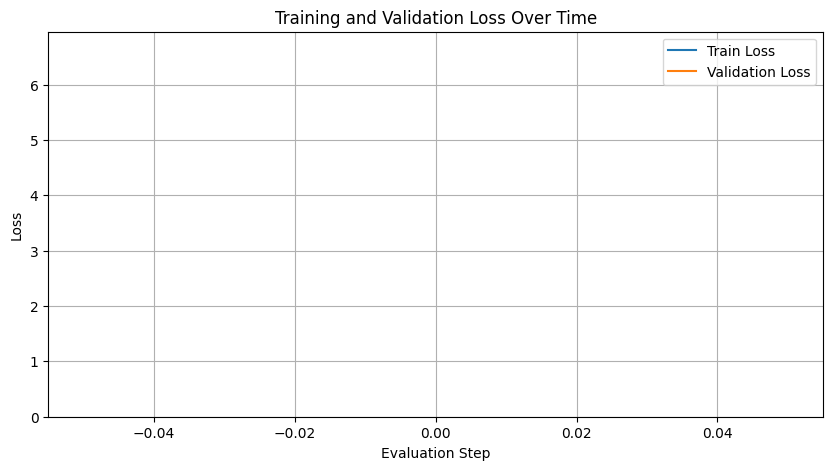

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylim(0)
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [17]:
input_tokens = tokenizer.encode("ki korisa")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=50)

print(tokenizer.decode(output[0].tolist()))

ki korisabisOk sun hothbo ThBila GoOja*uk �kuute 🥲🥲Sudilu use �AKio Aku nai tumar conAji ??Wow Bhal k 🫠 KorharBoilu vkam a Bila karone co�pai Ranek umak �asile bohut �kr
